In [209]:
import pickle
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200

In [210]:
with open("Data/data.pkl", "rb") as fp:   # Unpickling
    data_list = pickle.load(fp)
    
xpts, ypts, zpts, _, magpts = data_list

In [211]:
# check data
assert(len(xpts)==len(ypts) and len(xpts)==len(zpts) and len(xpts)==len(magpts))

In [212]:
# Transform the data into X, y form
n = len(xpts)
d = 3
X = np.array([xpts, ypts, zpts]).T
y = np.array(magpts)

In [ ]:
def valid_acc(model, dataset):
    y_predict = model.predict(dataset.valid_X)
    valid_acc = accuracy_score(dataset.valid_y, y_predict)
    return valid_acc

def shuffle_together(a, b, randstate = RANDSTATE):
    assert len(a) == len(b)
    p = randstate.permutation(len(a))
    return a[p], b[p]

class MyDataset():
    def __init__(self, valid_X, valid_y, train_X, train_y, test_X = None):
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y
        self.test_X = test_X
    def __str__(self):
        return str((self.train_X.shape, self.train_y.shape, self.valid_X.shape, self.valid_y.shape))

def train(dataset, n_using, C = 1):
    # to use all data, use n_using = -1
    X, y = dataset.train_X, dataset.train_y
    X, y = X[:n_using], y[:n_using].ravel()
    model = SVC(kernel='linear', C=C)
    model.fit(X, y)
    
    y_predict = model.predict(X)
    train_acc = accuracy_score(y, y_predict)
    
    return model, train_acc

def test(model, dataset):
    # test a model on the validation set
    y_predict = model.predict(dataset.valid_X)
    valid_acc = accuracy_score(dataset.valid_y, y_predict)
    return valid_acc
    
def train_test(dataset, n_using):
    model, train_acc = train(dataset, n_using)
    valid_acc = test(model, dataset)
    return valid_acc, train_acc

def plot_acc(xl, yl, zl, filename, title):
    plt.plot(xl, yl, label="validation")
    plt.plot(xl, zl, label="training")
    plt.title(title)
    plt.xlabel("number of training data points")
    plt.ylabel("accuracy")
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
# A code snippet to help you save your results into a kaggle accepted csv
def results_to_csv(y_test, title = 'submission.csv'):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(title, index_label='Id')

In [283]:
alpha = 0.1
kernel = Matern(nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, alpha=alpha).fit(X[:-20], y[:-20])

# check
print("Training score:%f"%gpr.score(X[:-20], y[:-20]))
print("Test score:%f (This should be slightly less than training, otherwise decrease alpha)"%gpr.score(X[-20:], y[-20:]))
gpr = GaussianProcessRegressor(kernel=kernel,random_state=1, alpha=alpha).fit(X, y)

# TODO: randomize test set
# TODO: plot variance on the same plots

Training score:0.959037
Test score:0.963480 (This should be slightly less than training, otherwise decrease alpha)


In [284]:
# gpr.predict(X[1:2])

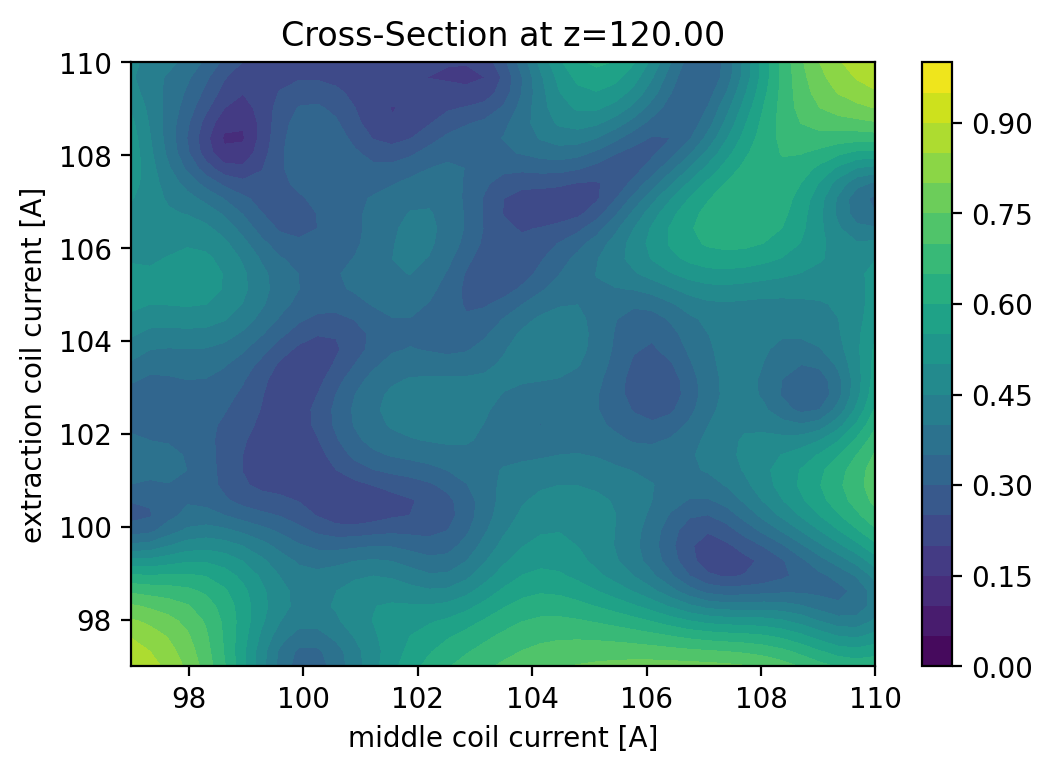

In [301]:
def plot_cross_section(gpr, z_plot, plotVar=False):
    def gauss_mean(x, y, z=123):
        arr = np.array([[x,y,z]])
        result = gpr.predict(arr)
        return result
    
    def gauss_var(x, y, z=123):
        arr = np.array([[x,y,z]])
        result = gpr.predict(arr, return_std=True)[1]
        return result
    if plotVar:
        func = gauss_var
    else:
        func = gauss_mean
    n_plot = 41
    x = np.linspace(97, 110, n_plot)
    y = np.linspace(97, 110, n_plot)
    z = np.array([func(i,j,z=z_plot) for j in y for i in x])

    X, Y = np.meshgrid(x, y)
    Z = z.reshape(n_plot, n_plot)
    
    levels = np.linspace(0, 1, 21) if plotVar else np.linspace(0, 170, 21)
    img=plt.contourf(X, Y, Z, levels=levels)
    plt.colorbar(img)
    
    
    plt.xlabel("middle coil current [A]")
    plt.ylabel("extraction coil current [A]")
    plt.title("Cross-Section at z=%.2f"%z_plot)
    filename = "Figures/GPRplots/var/z%d_var.png"%int(z_plot*10) if plotVar else "Figures/GPRplots/mean/z%d_mean.png"%int(z_plot*10)
    plt.savefig(filename)
    plt.show()
    return
plot_cross_section(gpr, 120, plotVar=True)

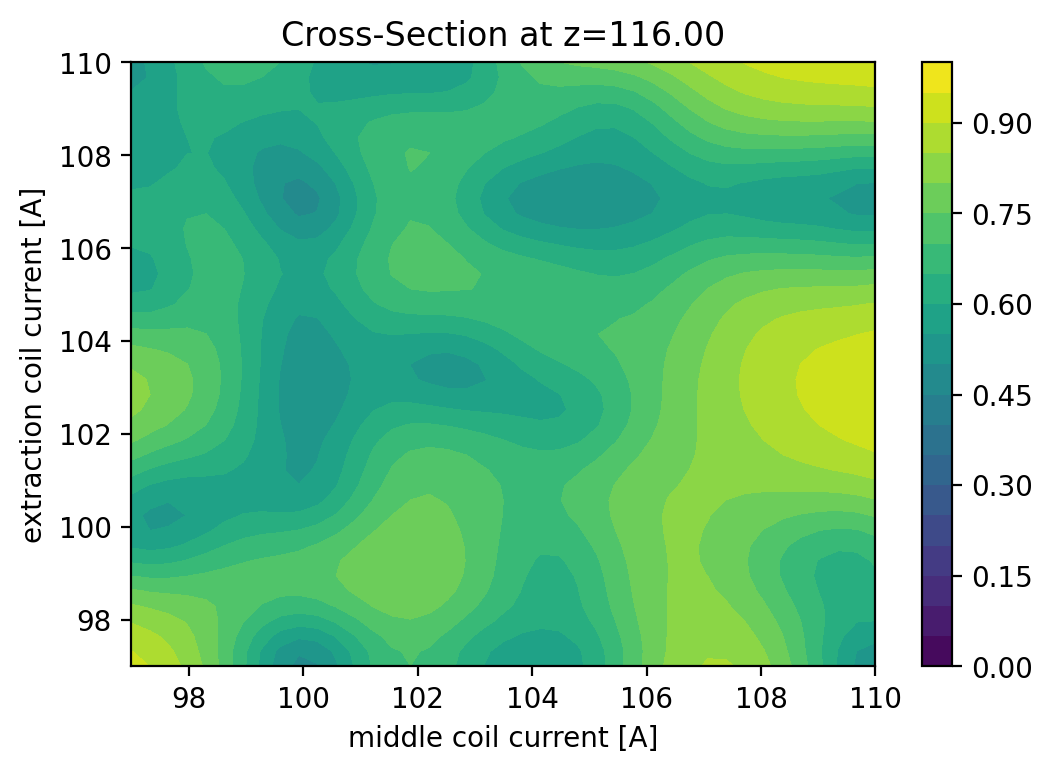

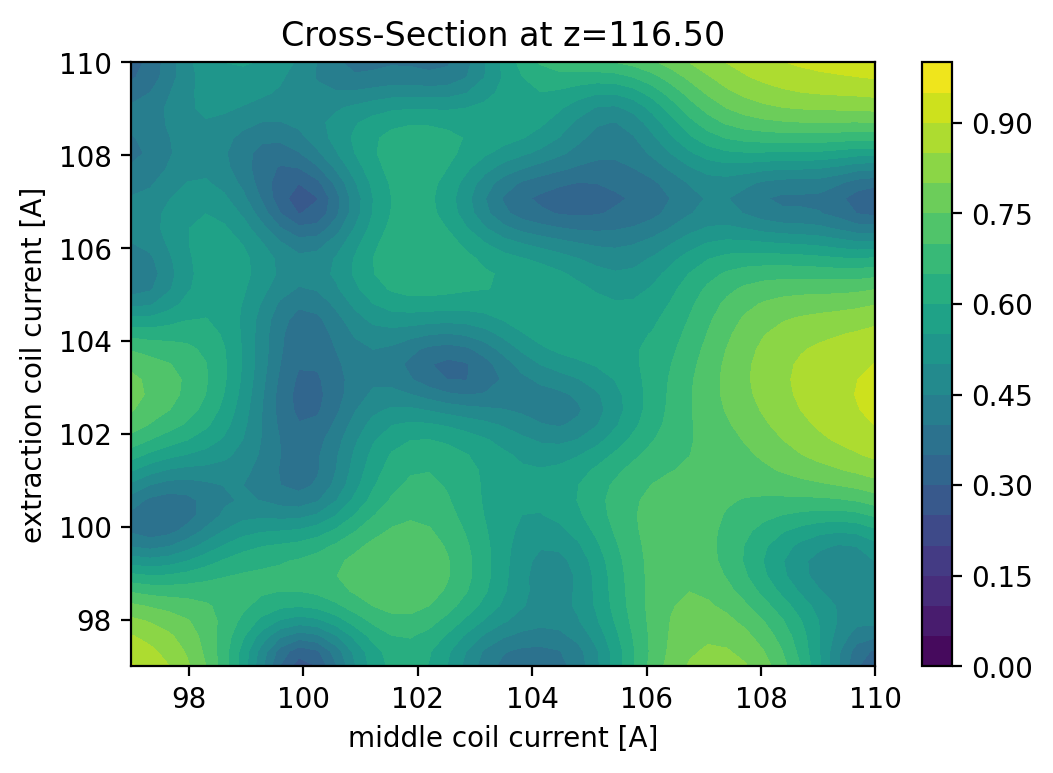

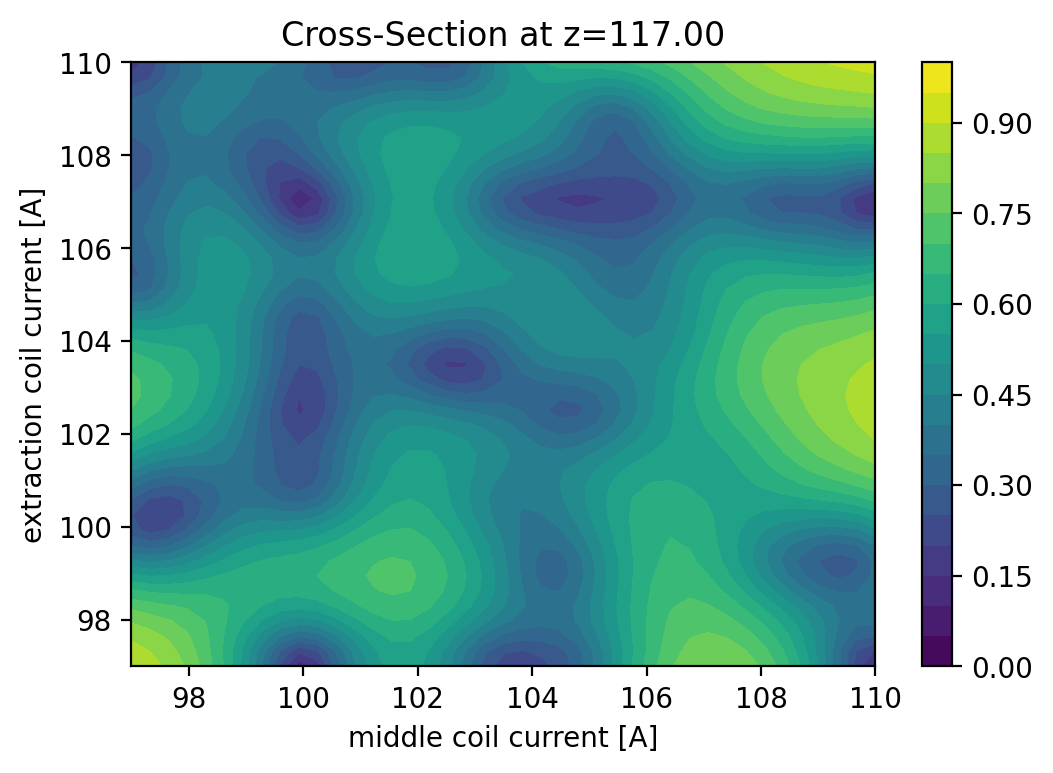

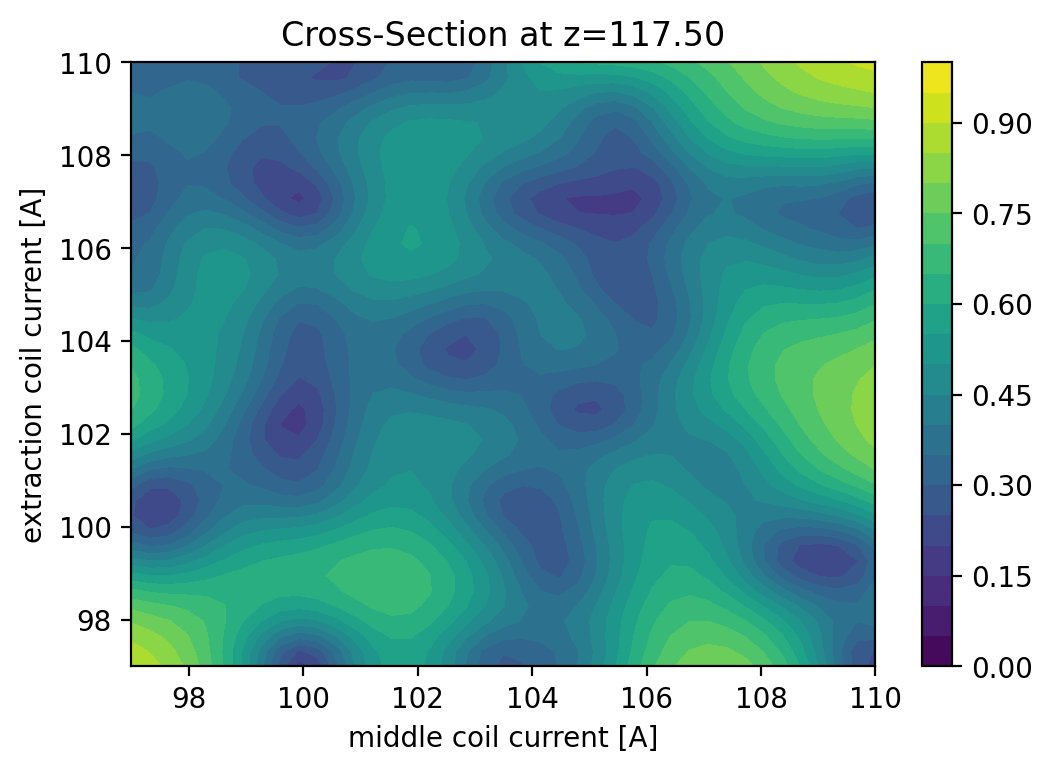

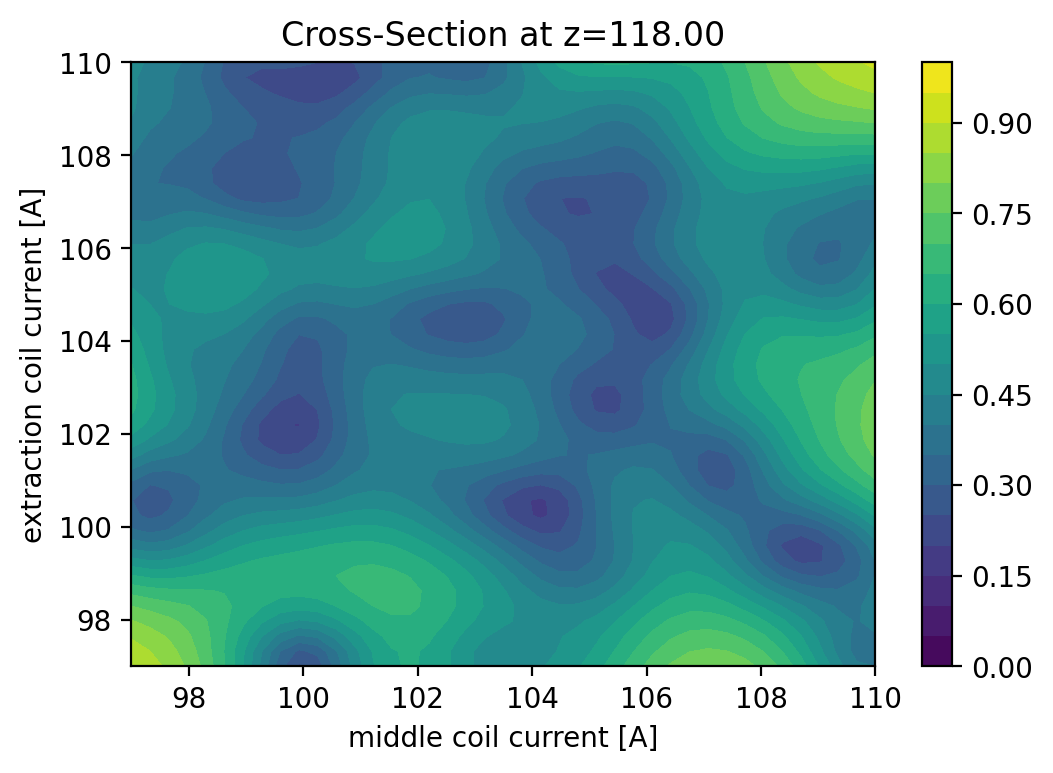

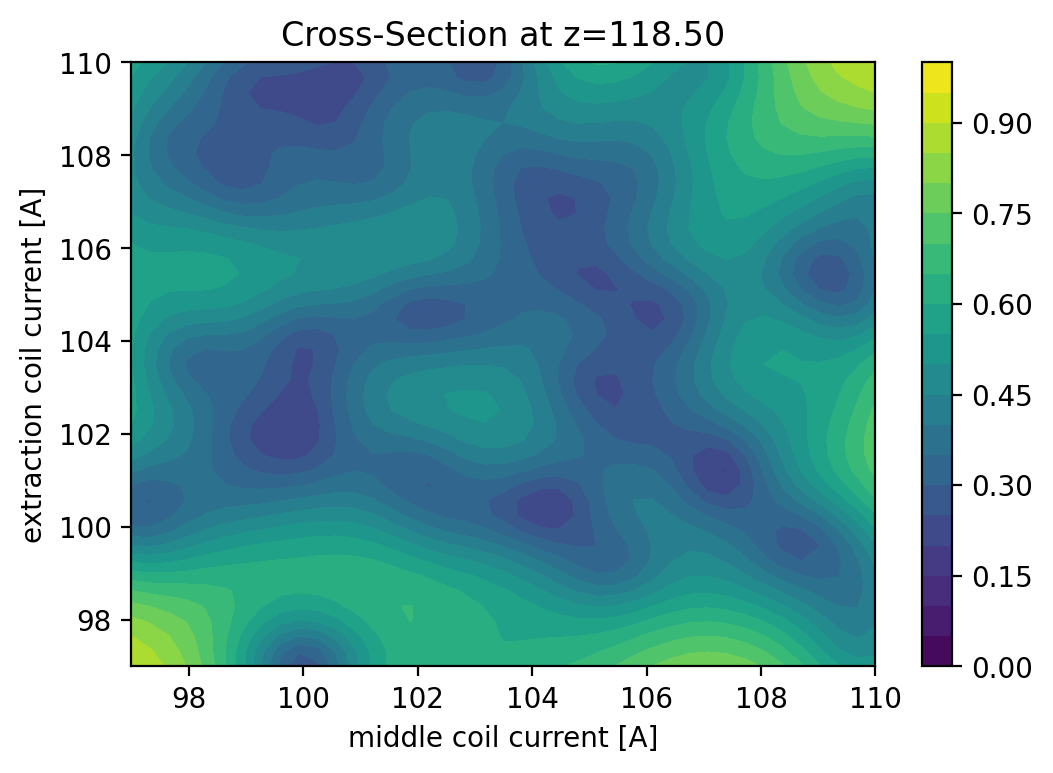

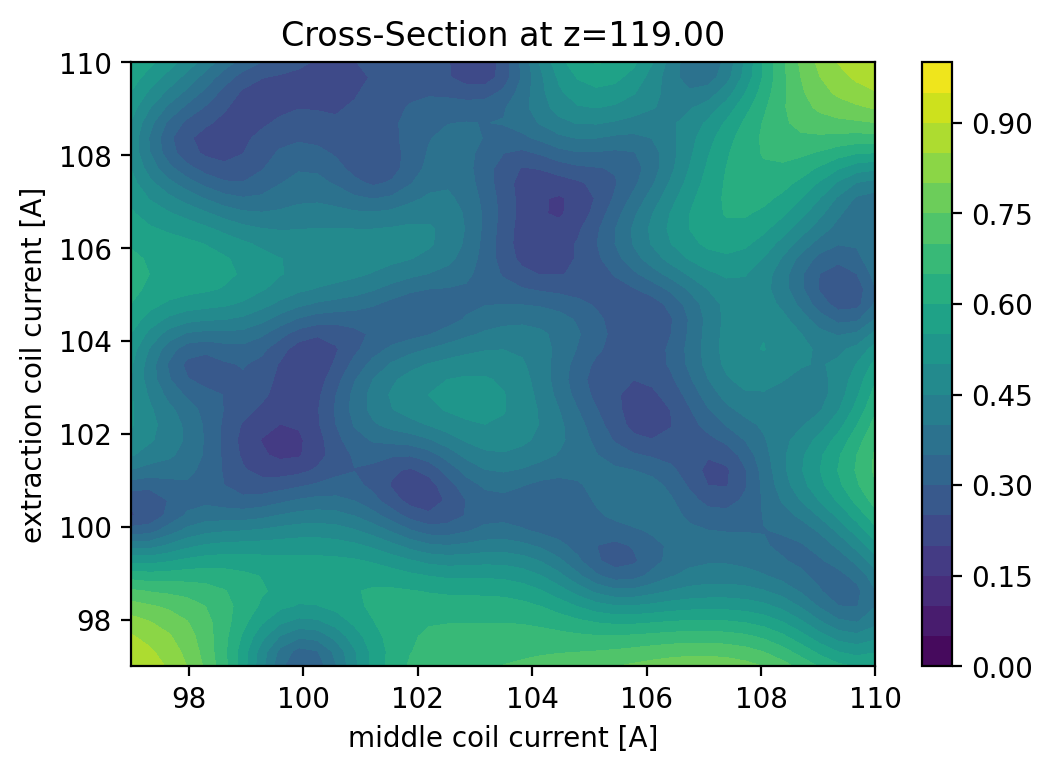

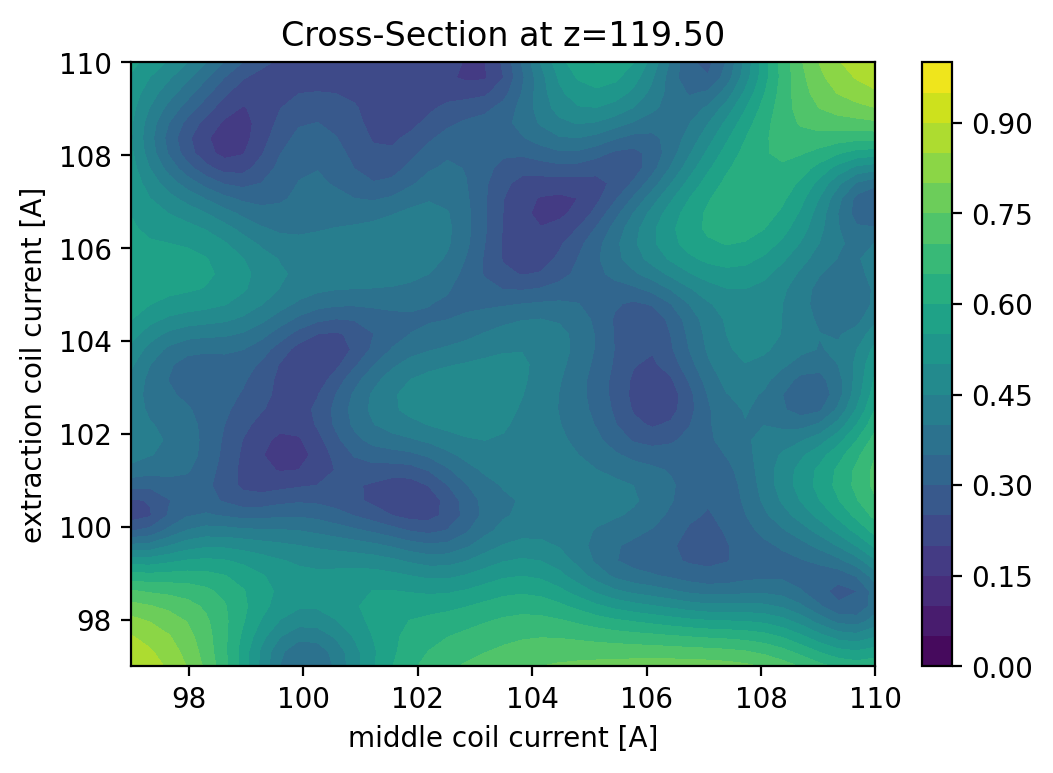

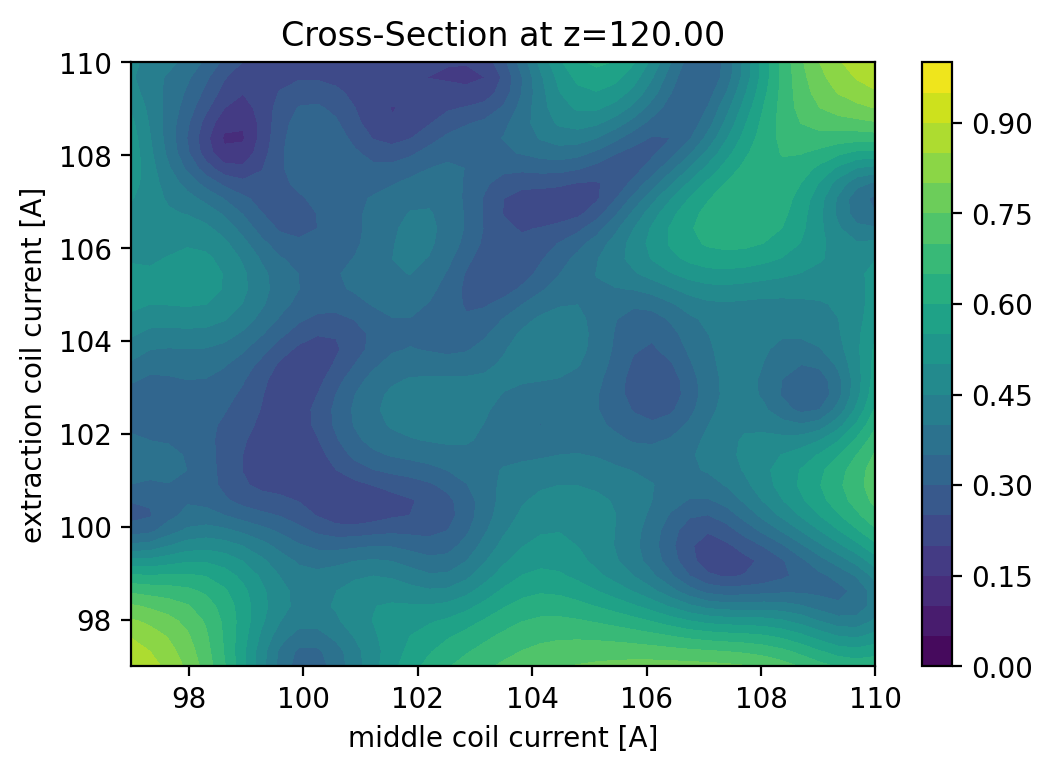

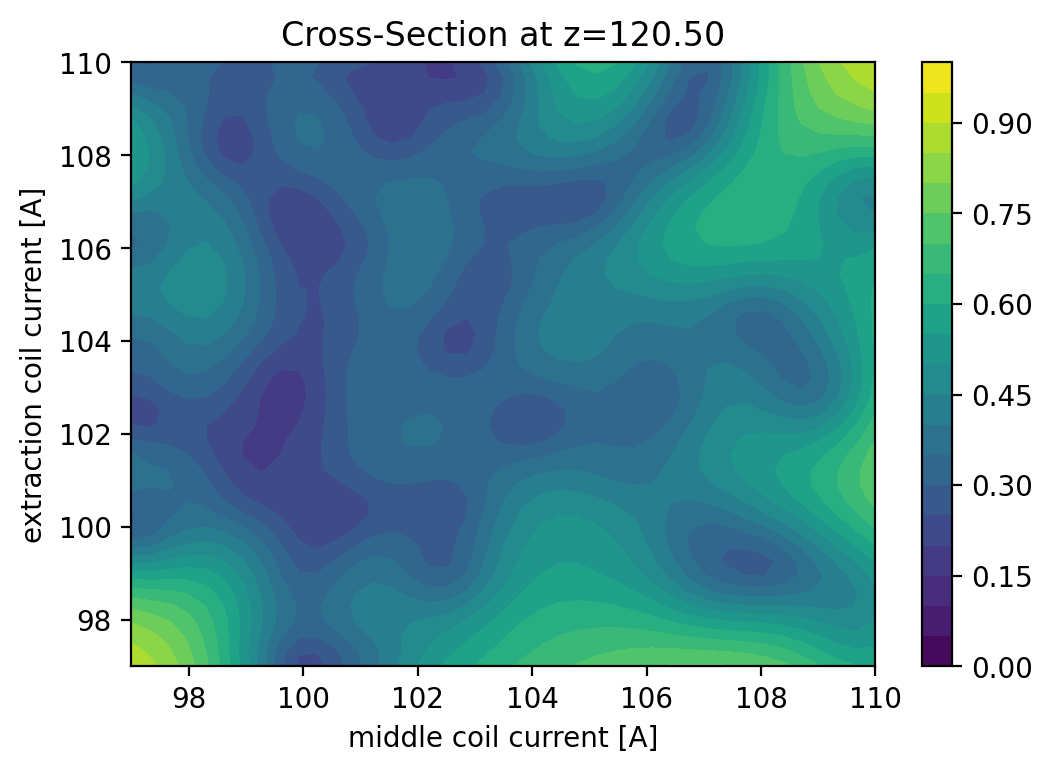

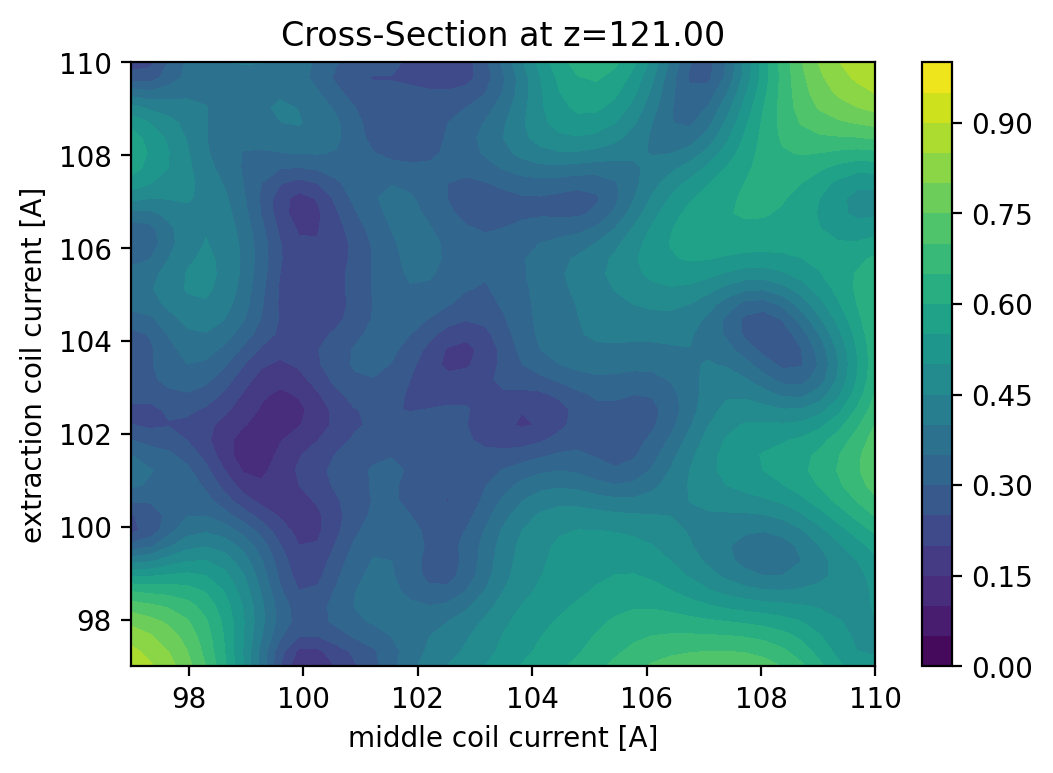

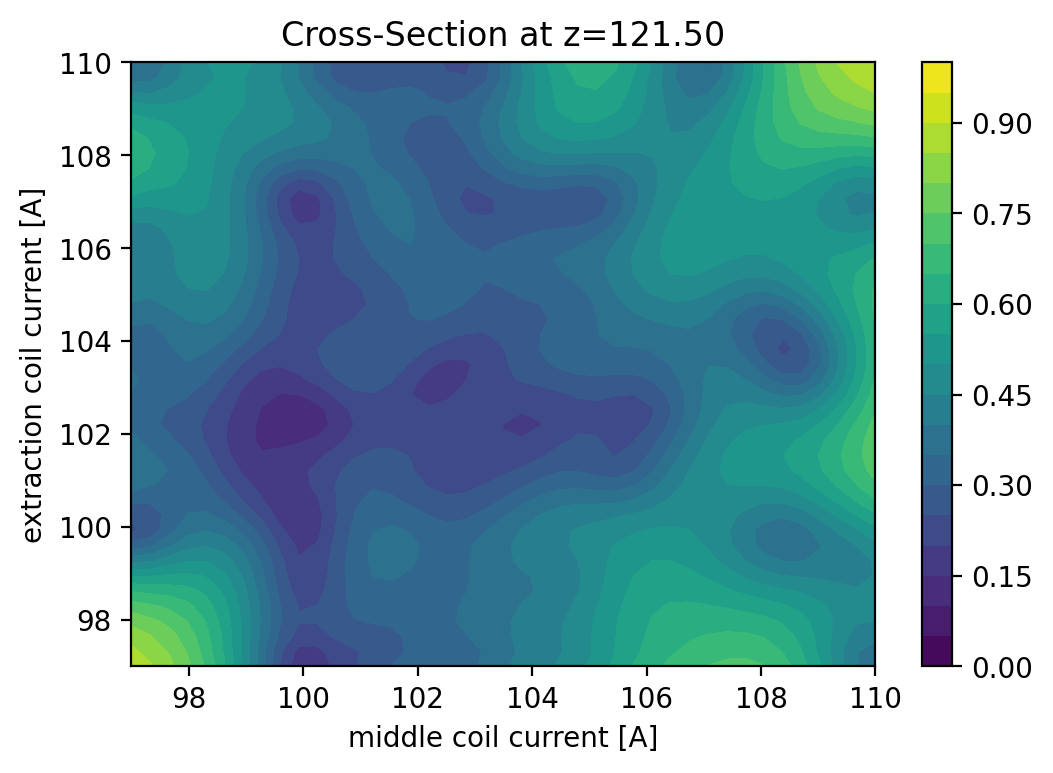

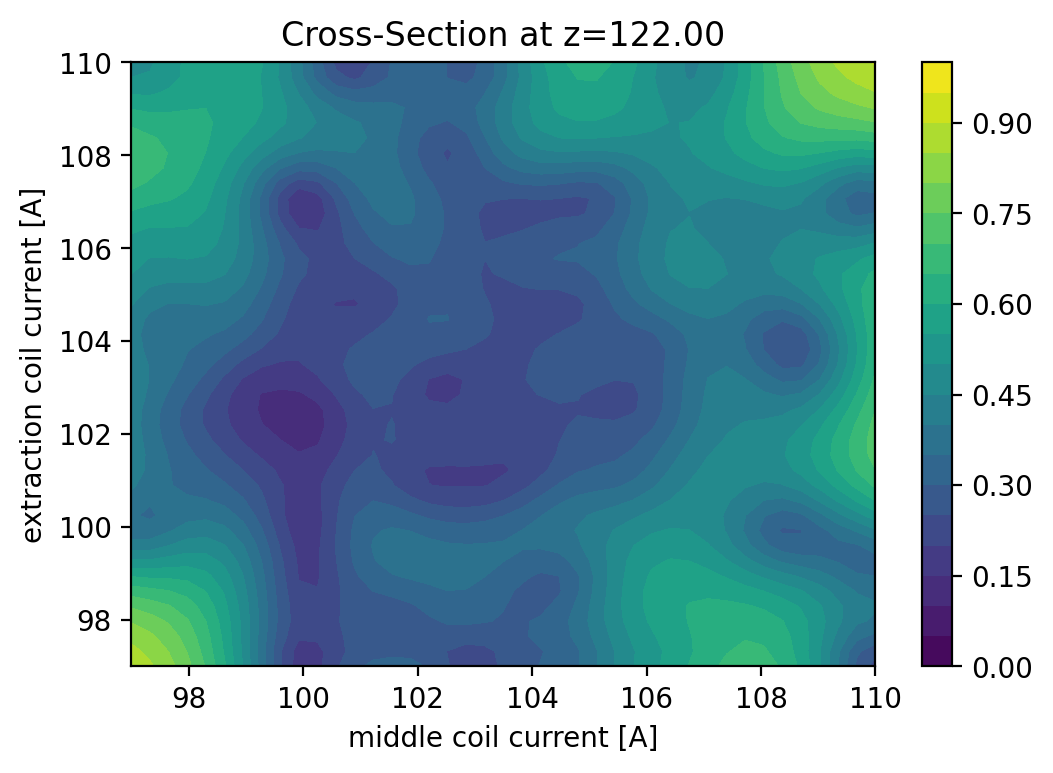

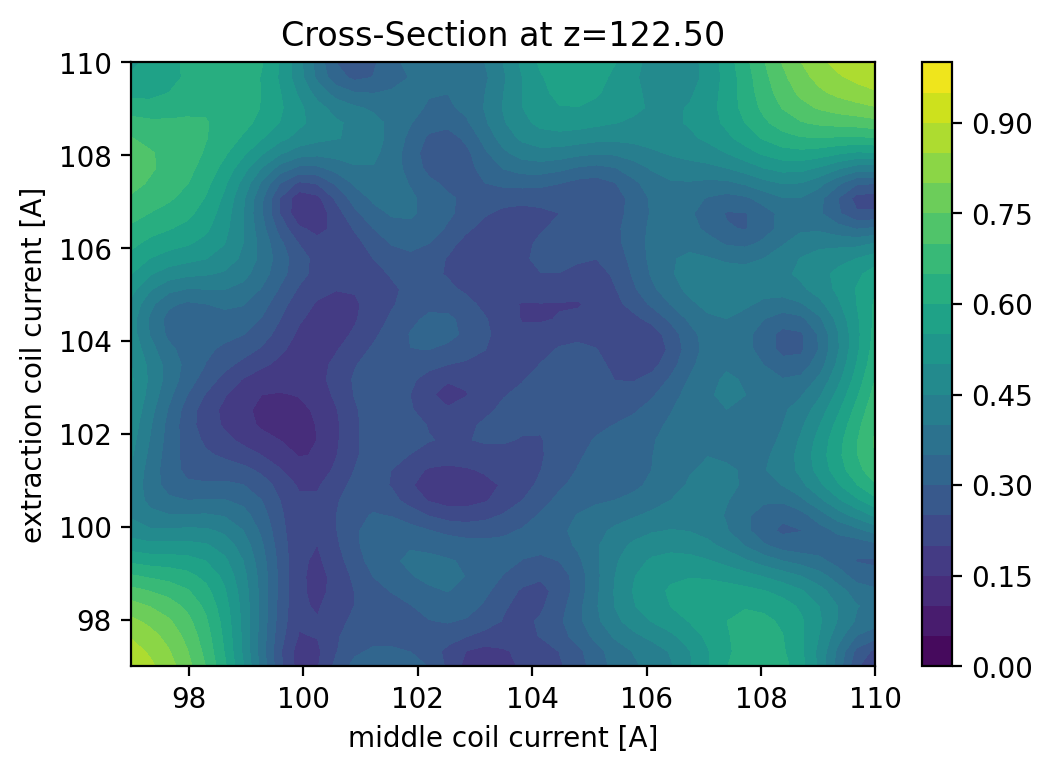

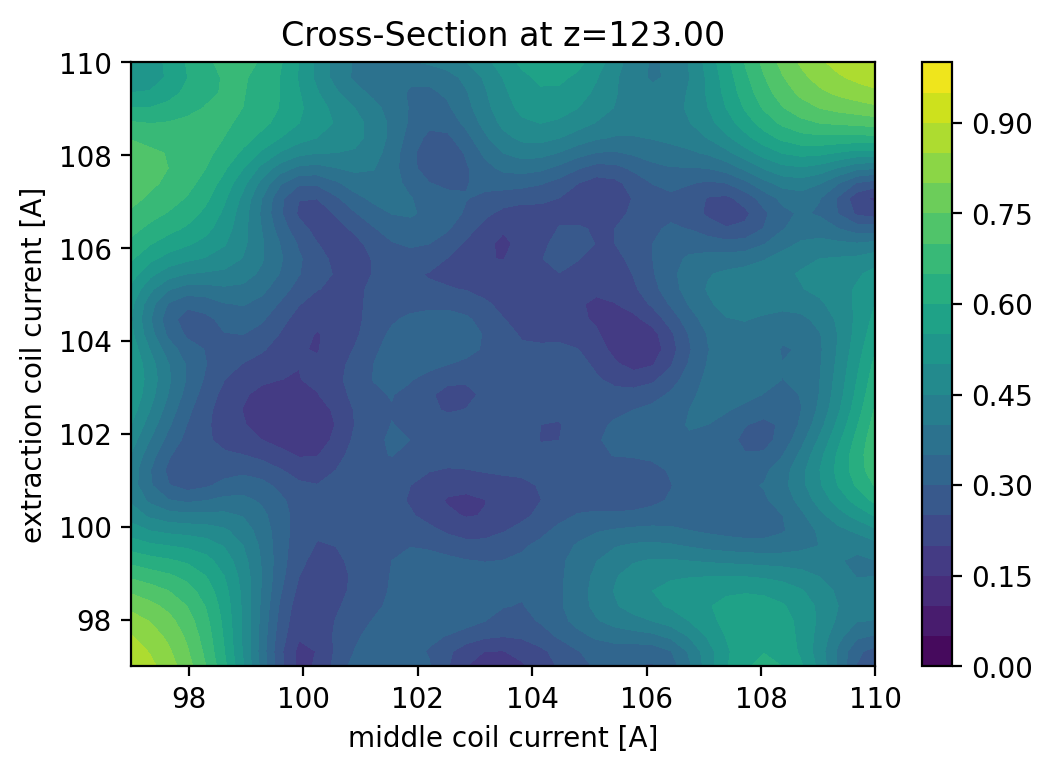

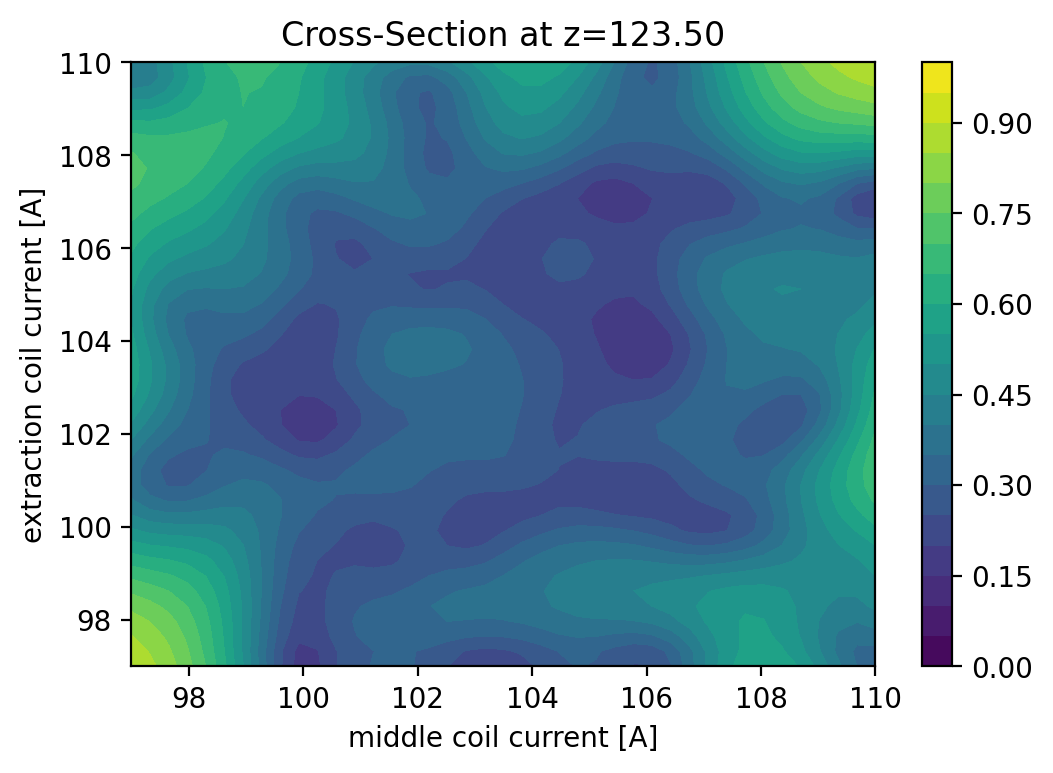

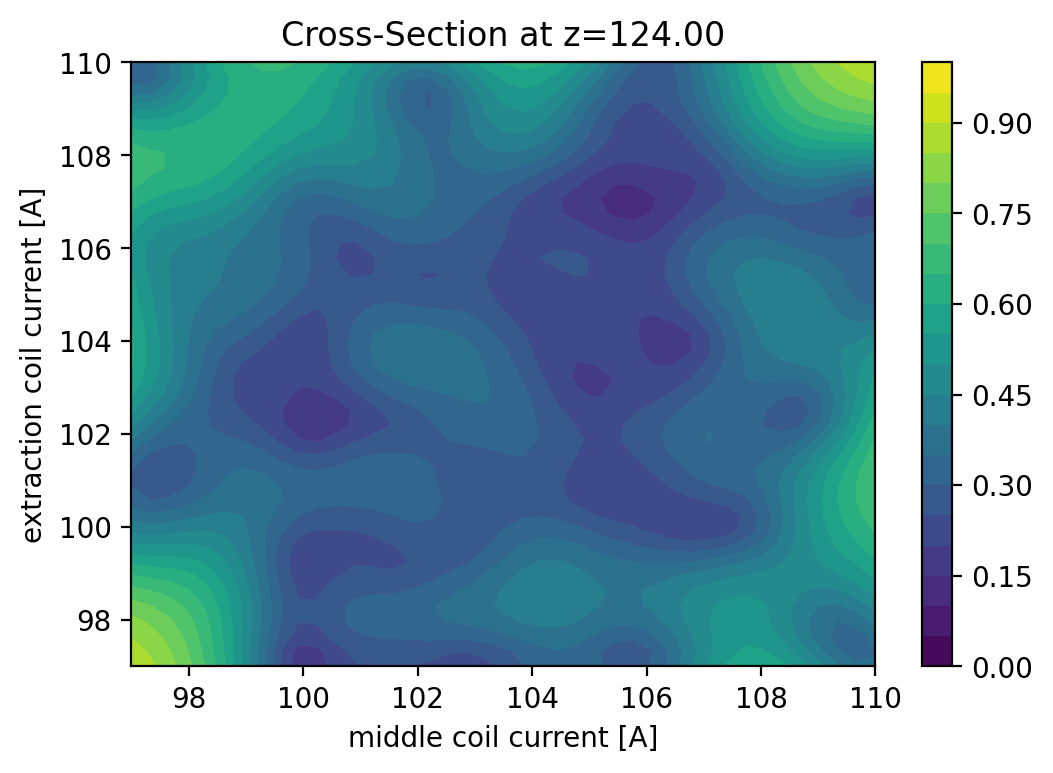

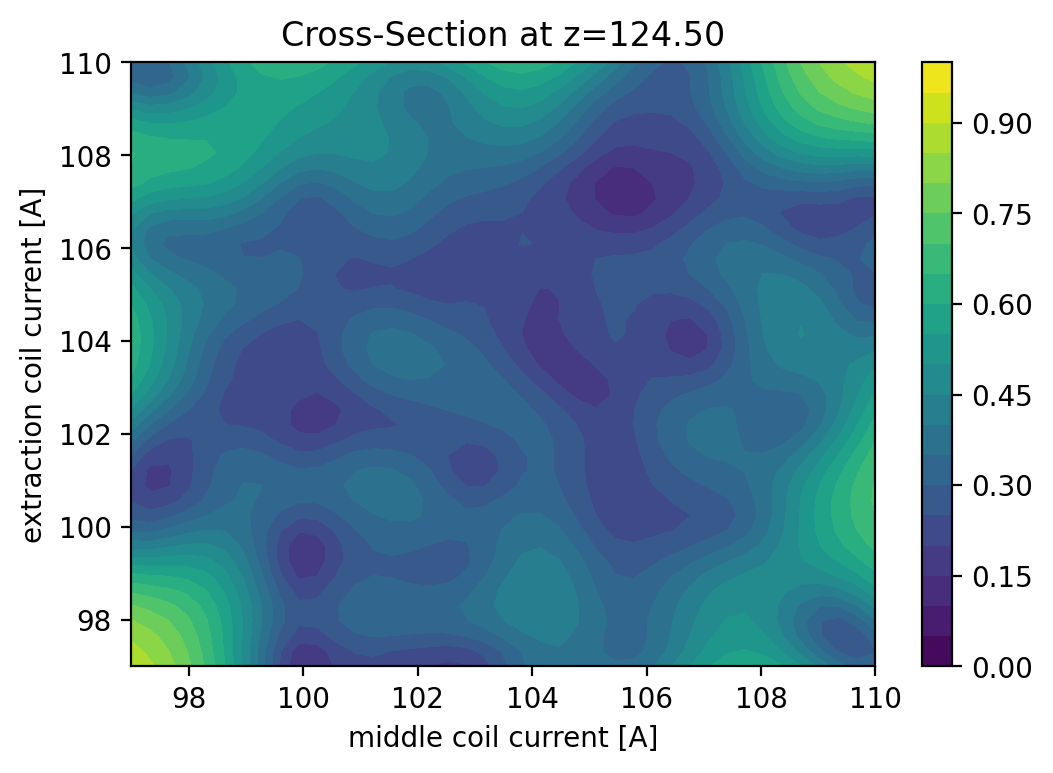

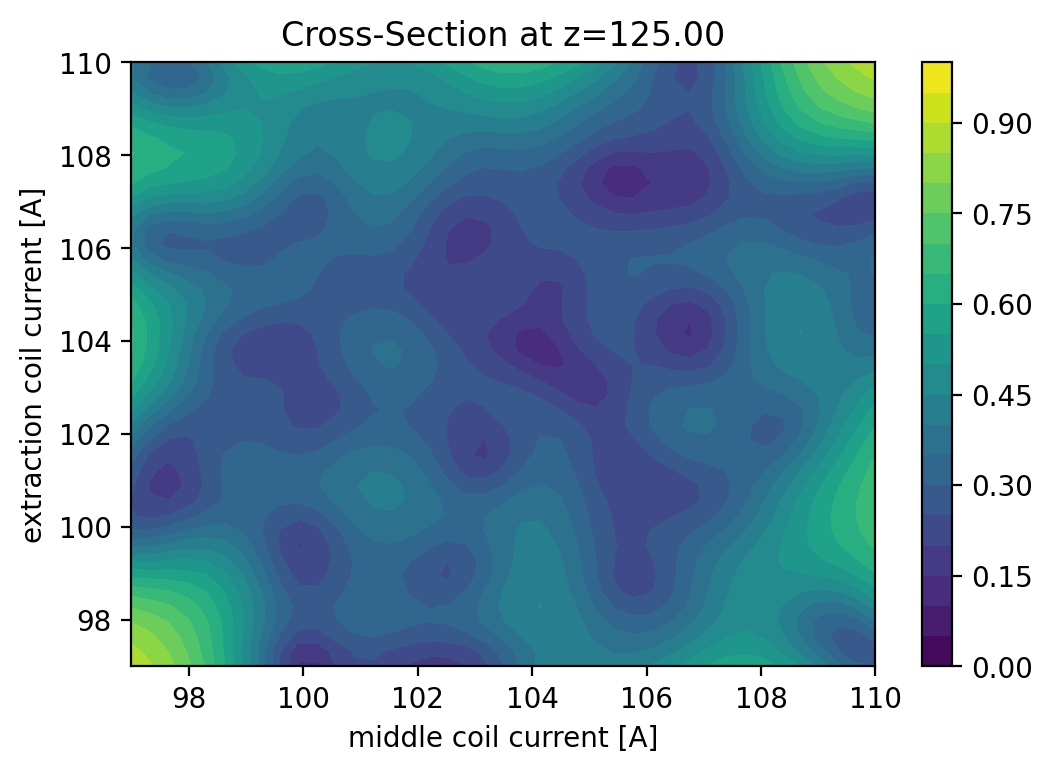

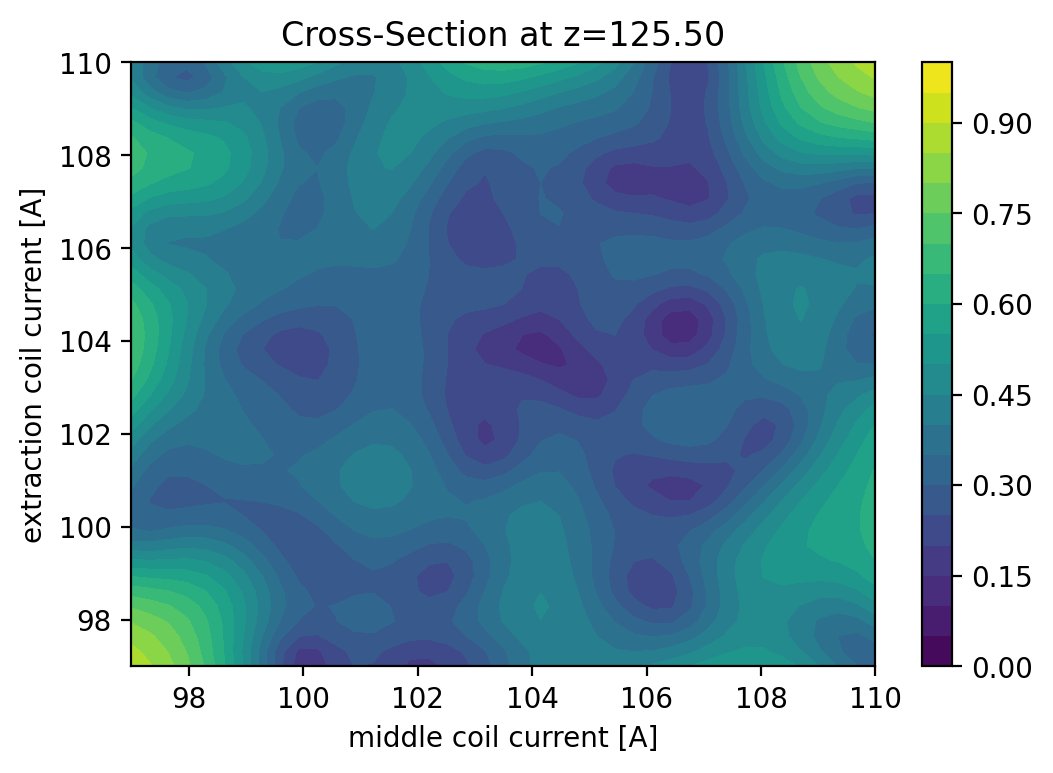

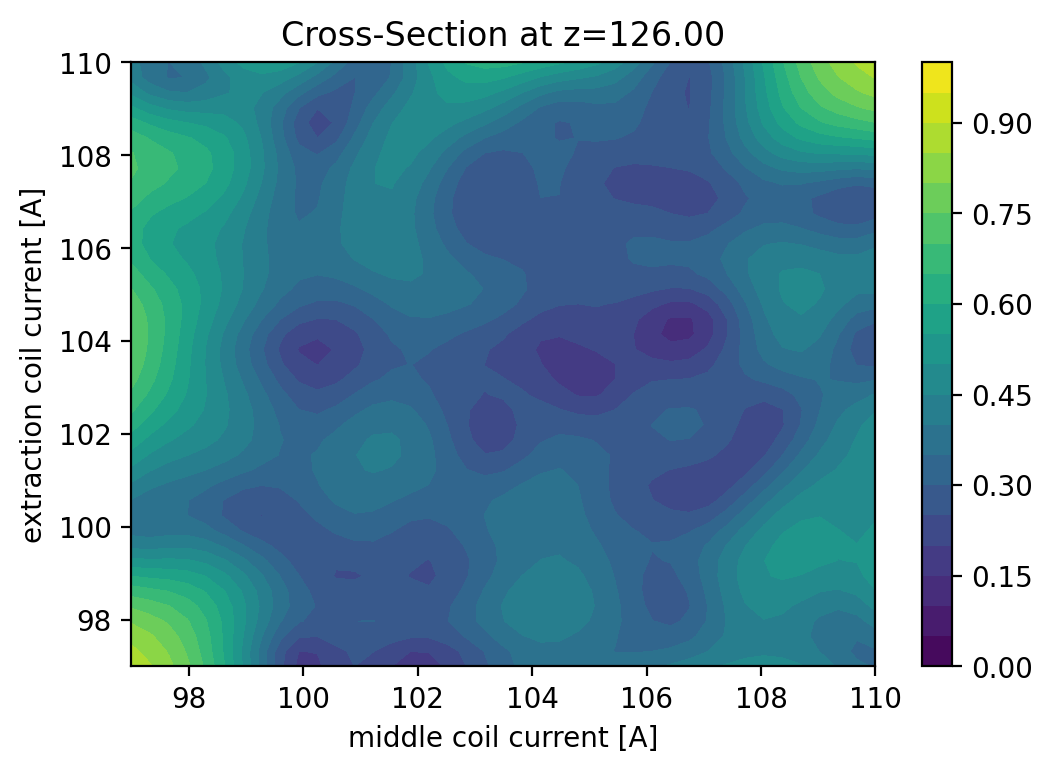

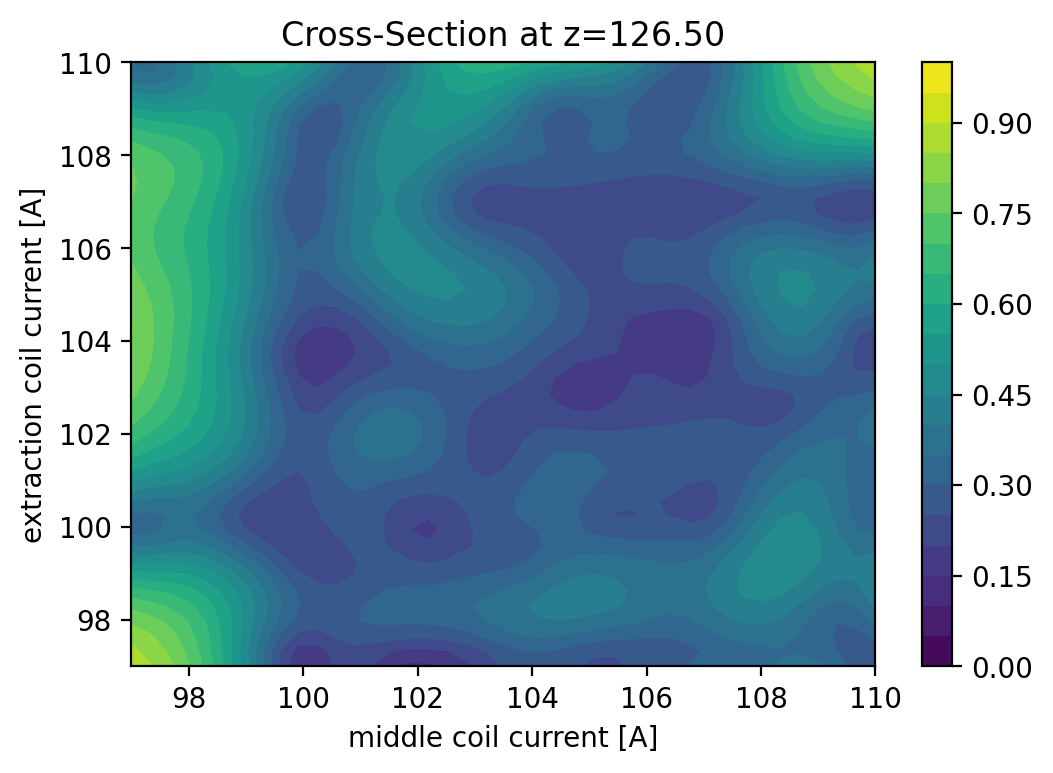

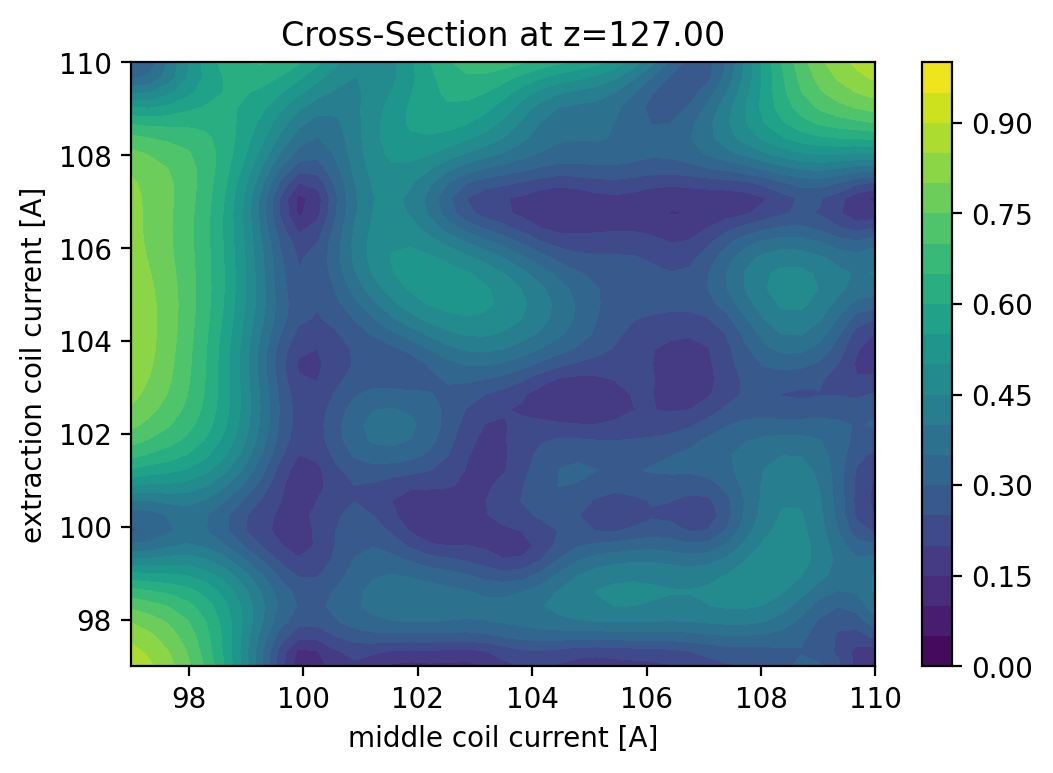

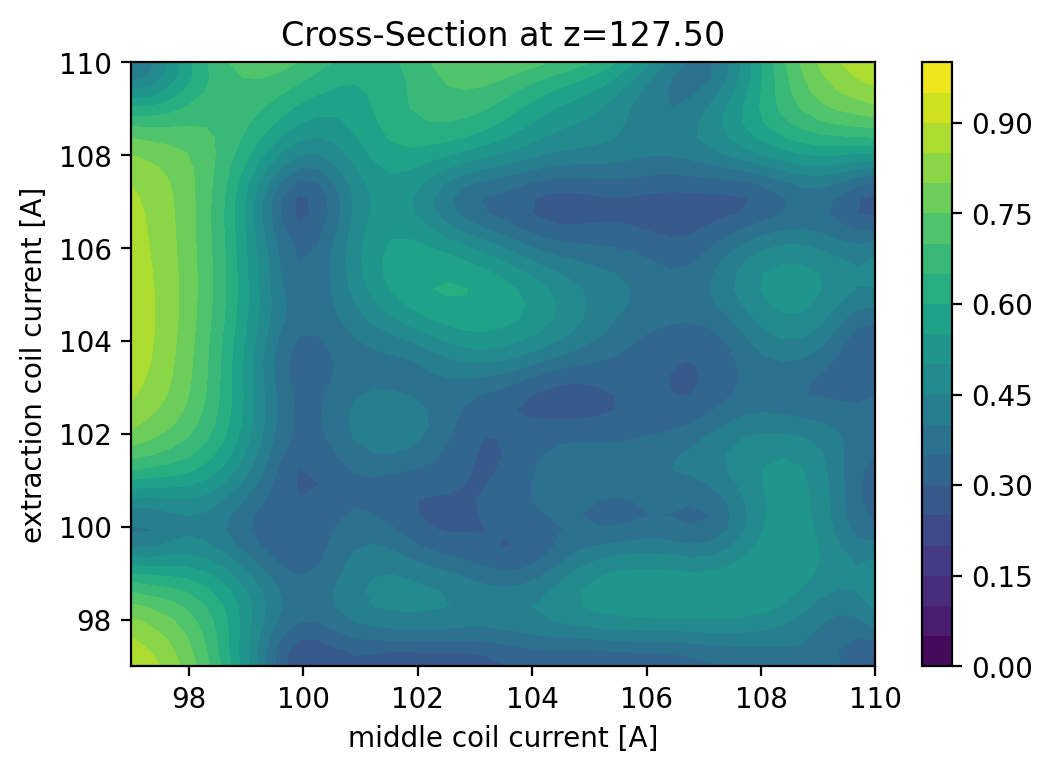

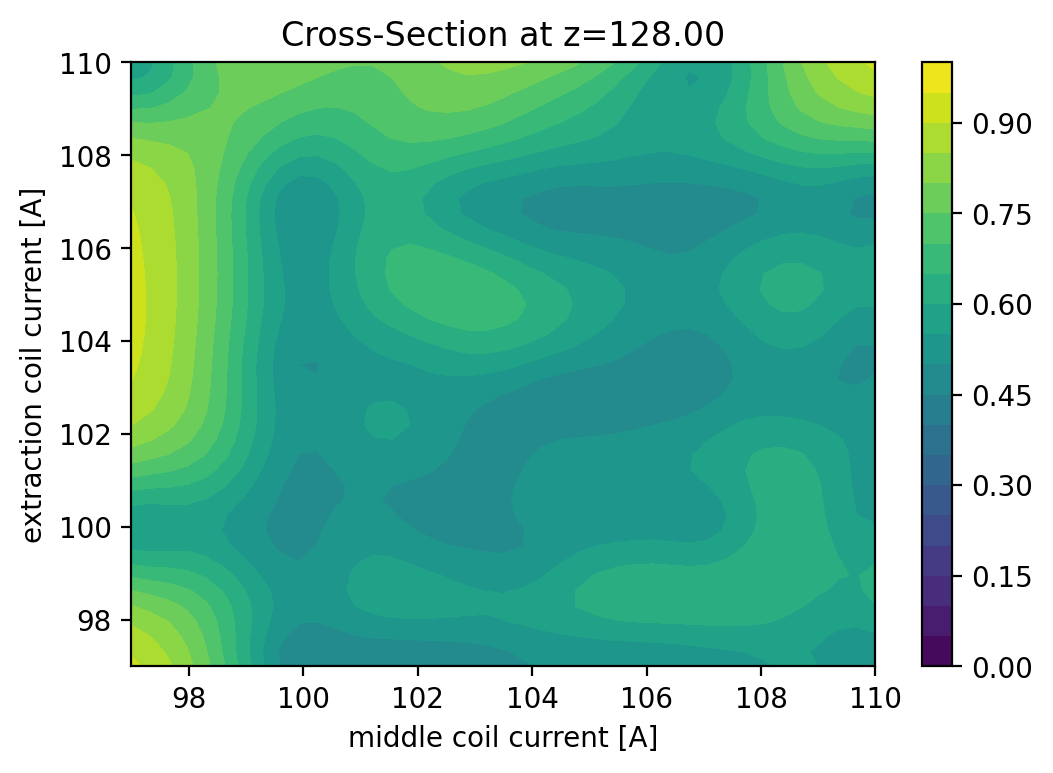

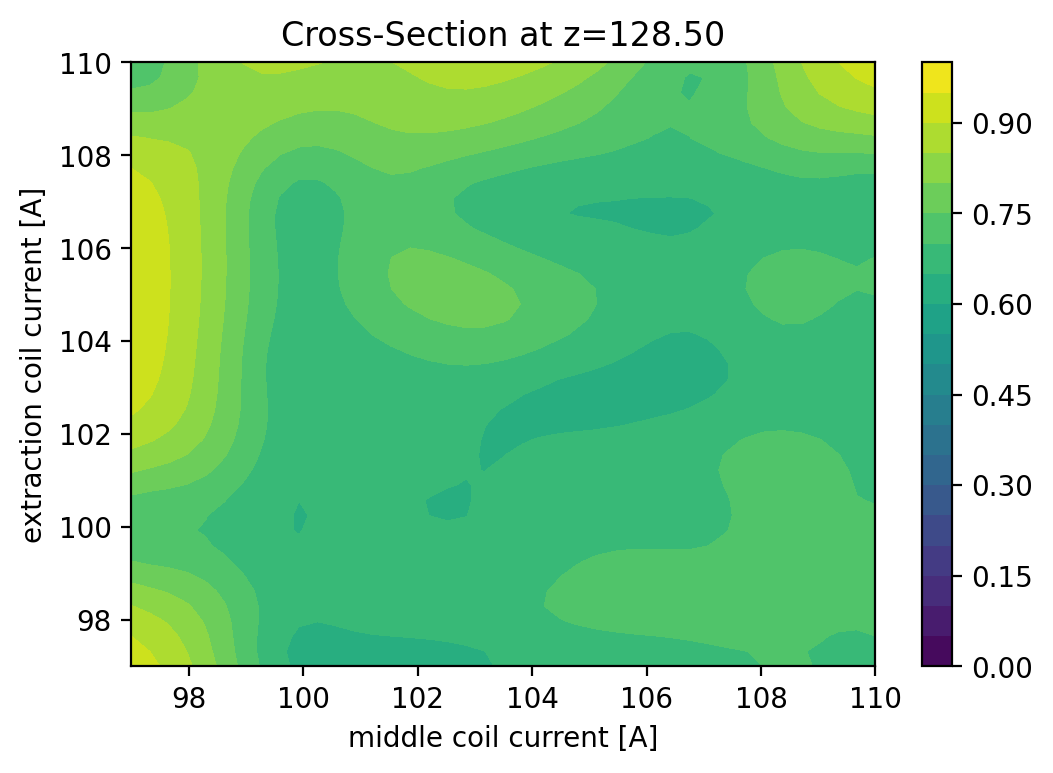

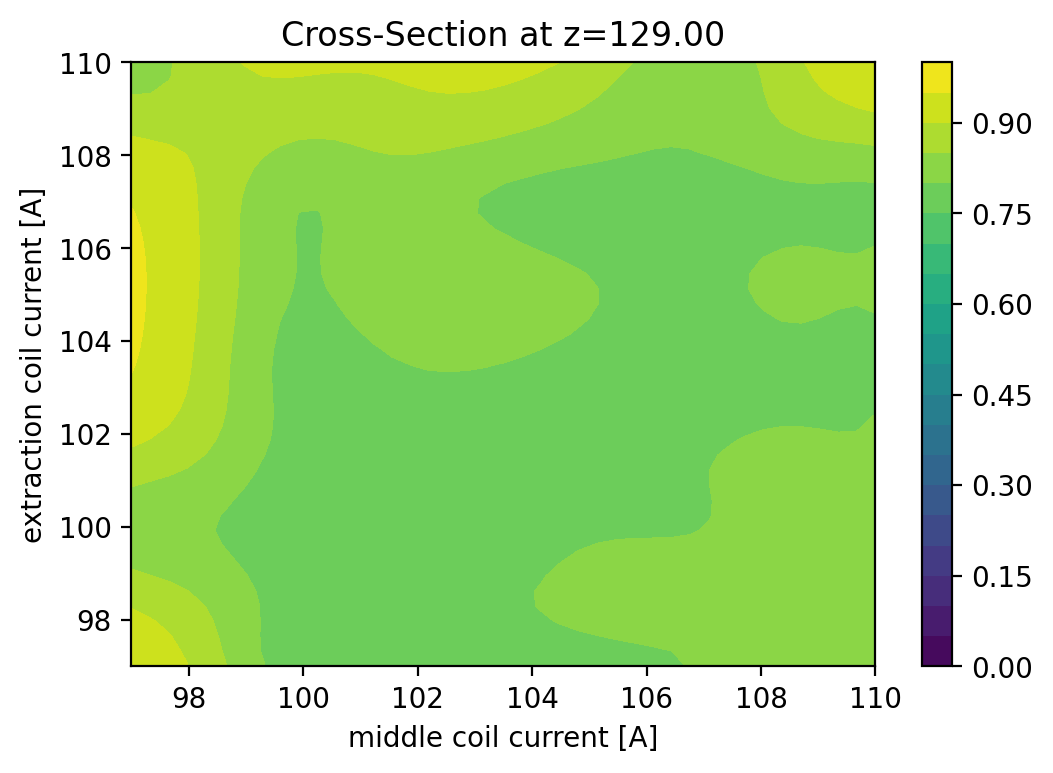

In [303]:
for z in np.linspace(116, 129, 27):
    plot_cross_section(gpr, z, plotVar=True)